In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
# import seaborn as sns
# sns.set_palette("hls")

In [2]:
c_perp = pd.read_csv('perp_data/TRAIN_PATH_CPERPLEXITY.csv')
x_perp = pd.read_csv('perp_data/TRAIN_PATH_XPERPLEXITY.csv')
combine = pd.merge(c_perp,x_perp)

In [3]:
x_threshold = 0.8
c_threshold = np.percentile(combine['C_PERPLEXITY'],30)
print(x_threshold,c_threshold)

0.8 1.2091026457651561


In [4]:
print("THe number of examples <c_threshold AND >x_threshold :",combine[(combine['C_PERPLEXITY'] <= c_threshold) & (combine['X_PERPLEXITY'] >= x_threshold)].shape[0])

THe number of examples <c_threshold AND >x_threshold : 997


In [5]:
def get_class(path):
    """
    Return the label the example belogns to according to path
    """
    return path.split('/')[2]
id_label_map = pd.read_csv('data/id_label_map.csv')
mapper = dict(zip(id_label_map['Nums'],id_label_map['Label']))

In [6]:
label_nums = Counter(combine['PATH'].apply(get_class)) #a dictionary record (label,# of training data)

In [7]:
prune = combine[(combine['C_PERPLEXITY'] < c_threshold) & (combine['X_PERPLEXITY'] > x_threshold)]
prune_label_nums = Counter(prune['PATH'].apply(get_class)) #a dictionary record (label,# of pruned data)
prune_label_nums = {k: v for k, v in sorted(prune_label_nums.items(), key=lambda item: item[1],reverse=True)} #sort dict on value in desc order

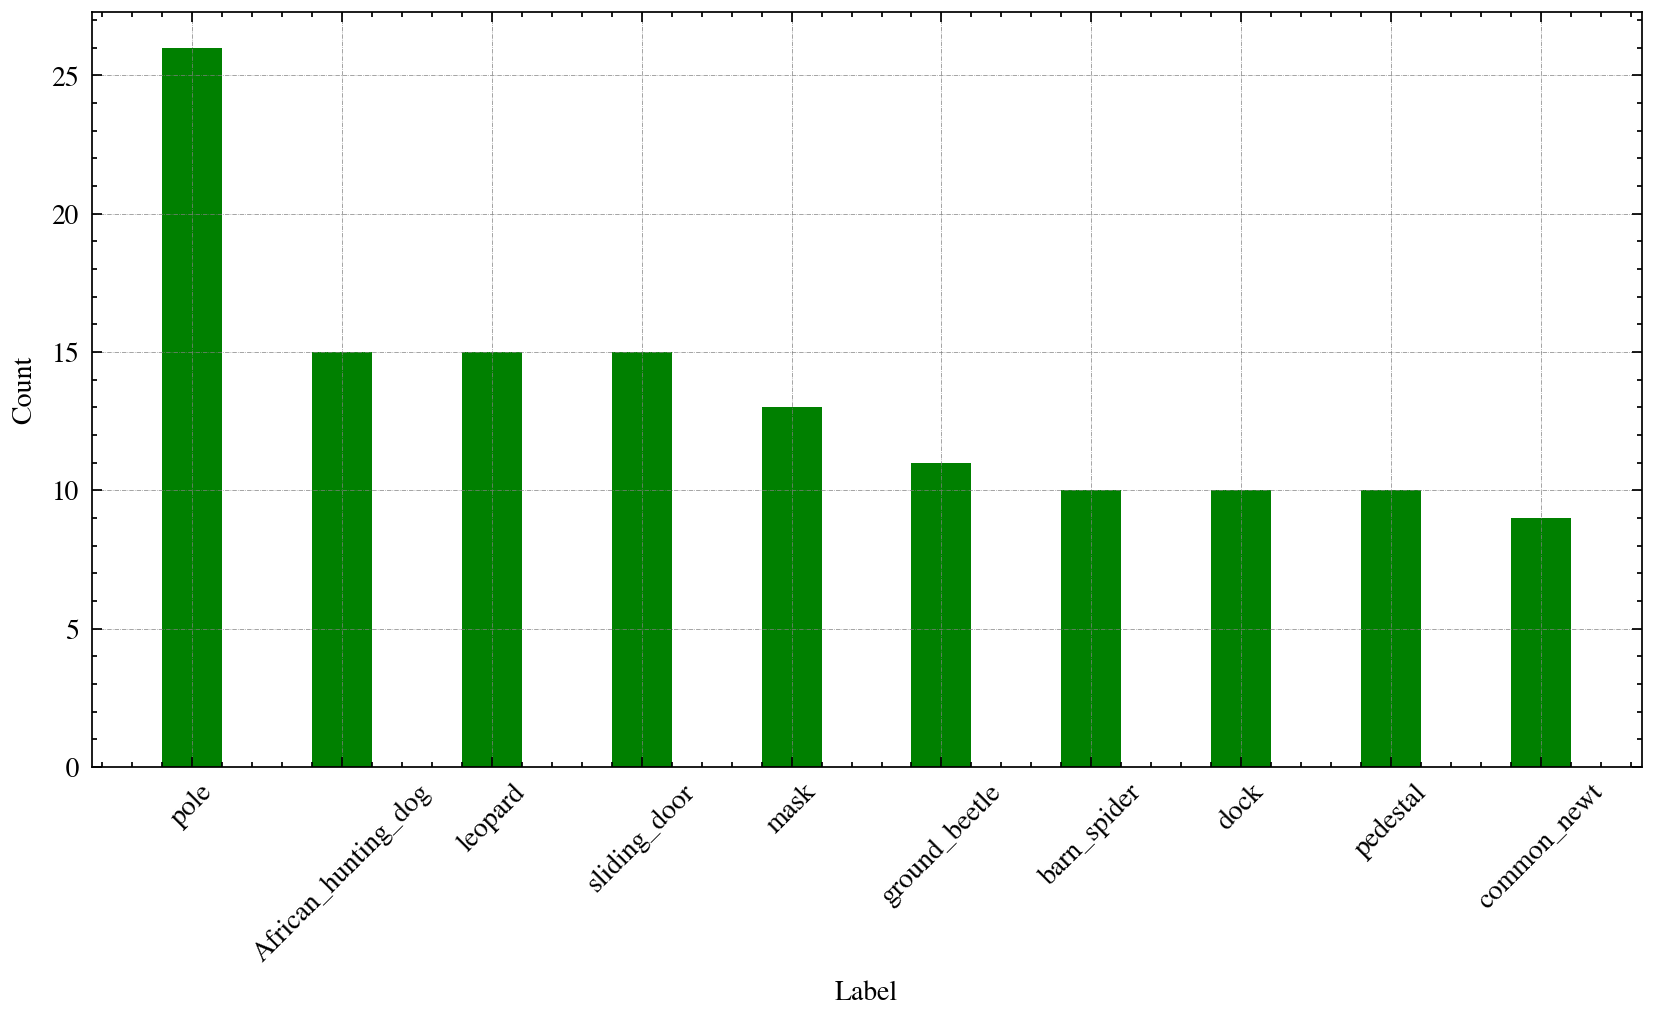

In [8]:
plt.style.use(['science','ieee','std-colors','no-latex'])
fig = plt.figure(figsize=[8,4],dpi=250)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.bar(list(map(mapper.get, list(prune_label_nums.keys())[0:10])),list(prune_label_nums.values())[0:10],width=0.4,color='green')
plt.xticks(rotation=45);
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('img/TOP_10_pruned_label_TVL.png',dpi=250, facecolor=fig.get_facecolor(),bbox_inches='tight')

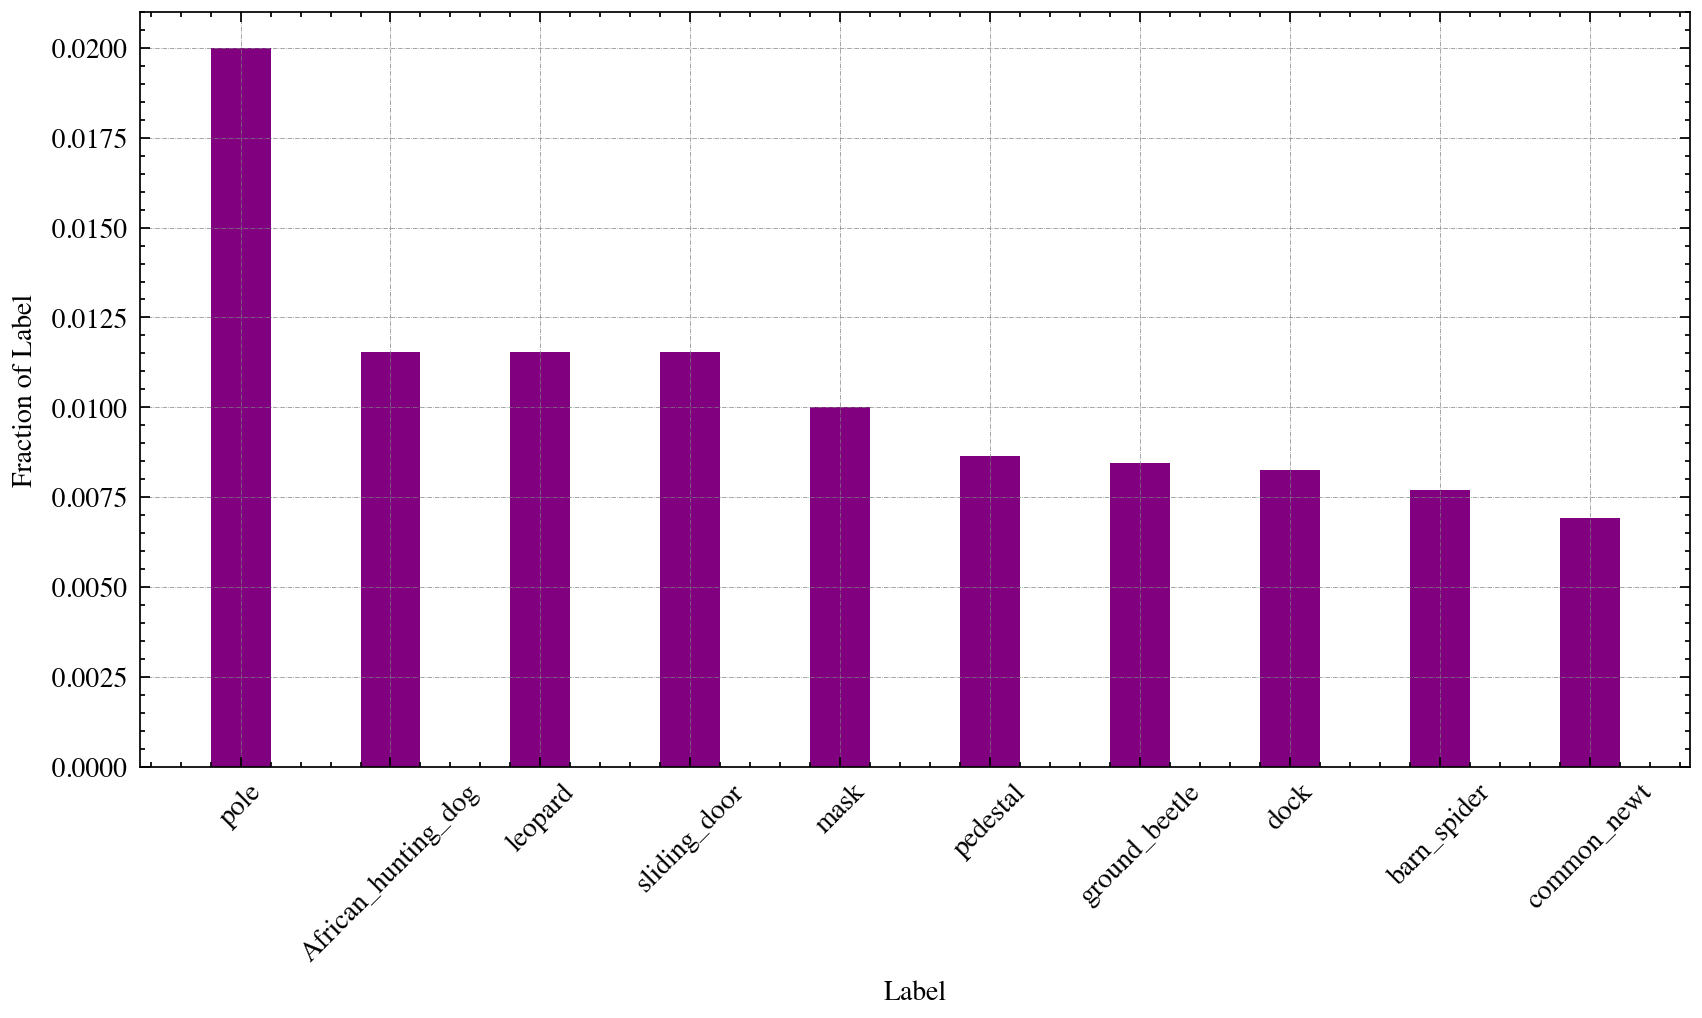

In [9]:
pruned_frac = {mapper[k]:prune_label_nums[k]/label_nums[k] for k in prune_label_nums.keys()} #calculate the fraction of pruned examples for classes will be pruned
pruned_frac = {k: v for k, v in sorted(pruned_frac.items(), key=lambda item: item[1],reverse=True)} #sort dict on value in desc order
plt.style.use(['science','ieee','std-colors','no-latex'])
fig = plt.figure(figsize=[8,4],dpi=250)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.bar(list(pruned_frac.keys())[0:10],list(pruned_frac.values())[0:10],width=0.4,color='purple')
plt.xticks(rotation=45);
plt.xlabel('Label')
plt.ylabel('Fraction of Label')
plt.savefig('img/TOP_10_frac_pruned_label_TVL.png',dpi=200, facecolor=fig.get_facecolor(),bbox_inches='tight')

In [10]:
mapper = pd.read_csv('data/id_label_map.csv')
id_label = dict(zip(mapper['ID'],mapper['Label']))
folder_id= dict(zip(mapper['Nums'],mapper['ID']))
def replace_path(x):
    return x.replace('./ILSVRC2012_img_train','/4tssd/imagenet/train')
def get_label(x):
    return folder_id[x.split('/')[4]]

In [11]:
combine = combine.drop(index = prune.index)
combine = combine.reset_index().drop(labels='index',axis=1) #reset index
combine = combine.sample(frac = 1) #shuffle the training data for training
combine['PATH'] = combine['PATH'].apply(replace_path)
combine['LABEL'] = combine['PATH'].apply(get_label)
combine.to_csv('data/'+'_PRUNED_TRAINING_TVL.csv',index=None)

In [12]:
labels,pruned_count = list(prune_label_nums.keys()),list(prune_label_nums.values())
pd.DataFrame({'LABEL':labels,'PRUNED_COUNT':pruned_count}).to_csv('data/'+'_PRUNED_COUNT_TVL.csv',index=None)